**Ejercicio 1**

*1.1 Calcular el monto total que facturará el proveedor del servicio por envíos de sms.*

In [25]:
#Import libreries
from pyspark.sql.functions import when,sum,md5,hour
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

In [33]:
# Create a Spark session
spark = SparkSession.builder.appName("ReadFile").getOrCreate()

# Read a CSV file
df_events = spark.read.csv("/home/jovyan/test_grandata_data_engineer/events.csv.gz", header=True, inferSchema=True)
df_freesms = spark.read.csv("/home/jovyan/test_grandata_data_engineer/free_sms_destinations.csv.gz", header=True, inferSchema=True)

df_payed = df_events.join(df_freesms,df_events.id_destination == df_freesms.id,"leftanti") 
df_payed = df_payed.filter((df_payed.id_source.isNotNull()) & (df_payed.id_destination).isNotNull())
df_payed = df_payed.filter(df_payed.sms != 0)

df_payed = df_payed.withColumn("toPay",
                               when(((df_payed.region >= 1) & (df_payed.region <= 5)) , 1.5)
                               .when(((df_payed.region >= 6) & (df_payed.region <= 9)), 2.0)
                               .otherwise(None))

total_sum = df_payed.agg(sum("toPay")).collect()[0][0]
# Show answer
print('El monto total a facutrar por el proveedor por sms es: $',total_sum)
print('---------------------------')


+----+-----+-------+---+----+------+---------+--------------+
|hour|calls|seconds|sms|date|region|id_source|id_destination|
+----+-----+-------+---+----+------+---------+--------------+
+----+-----+-------+---+----+------+---------+--------------+

El monto total a facutrar por el proveedor por sms es: $ 140757.0
---------------------------


*1.2 Generar un dataset que contenga los ID de los 100 usuarios con mayor facturación por
envío de sms y el monto total a facturar a cada uno. Además del ID, incluir el ID
hasheado mediante el algoritmo MD5. Escribir el dataset en formato parquet con
compresión gzip.*

In [27]:
df_maxpinvoice = (
    df_payed
    .groupBy("id_source")
    .agg(sum("toPay").alias("total_payment"))
    .orderBy("total_payment", ascending=False)  # Order in descending order
    .limit(100)  # Limit to the first 100 rows
)

df_with_hash = df_maxpinvoice.withColumn("hashed_id", md5(df_maxpinvoice.id_source))
df_with_hash.show()

#Write the dataset
df_with_hash.write.format('parquet').option('compression', 'gzip').mode('overwrite').save('/home/jovyan/output/max_billing.csv.gz')
print('The file was write successfully in the folder output')

+---------+-------------+--------------------+
|id_source|total_payment|           hashed_id|
+---------+-------------+--------------------+
|      4D3|      18201.5|911914c7729eedbdf...|
|      76D|      13128.0|bd180b7811395cbce...|
|      07E|       3620.0|14a0660ae2f5d1868...|
|      541|       1361.0|16c222aa19898e505...|
|      B86|        950.5|bc97b32ee2abb9c18...|
|      3AE|        672.0|6a57072949dbc409c...|
|      1BD|        657.5|f5a45e33602ea62f9...|
|      3E0|        628.5|e9d076deb3451cc49...|
|      E6F|        318.0|159e1f3d6ff0e7c3c...|
|      D0B|        291.5|e87c495061191f4df...|
|      BD4|        274.5|aa35b36e4d1395542...|
|      8F1|        269.5|496ce5f942d15eefb...|
|      556|        212.5|11b921ef080f77360...|
|      E21|        206.0|6f916a6c36cd500c3...|
|      24F|        168.5|9f4c6198e4de6db74...|
|      498|        159.5|05f971b5ec196b8c6...|
|      ED9|        134.5|7d7d2b7b7d0b01a87...|
|      2B1|        123.5|2cf07ff95f0cec031...|
|      79F|  

*1.3 Graficar un histograma de cantidad de llamadas que se realizan por hora del día.*

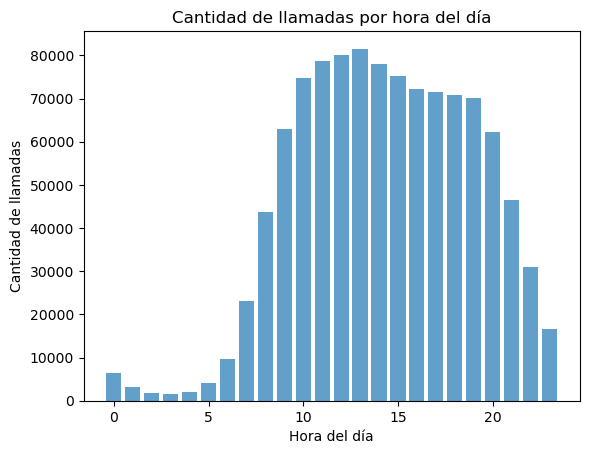

In [28]:
# Crear una sesión de Spark
#spark = SparkSession.builder.appName("example").getOrCreate()

# Supongamos que tienes un DataFrame llamado df_calls con una columna "timestamp" que contiene la marca de tiempo de cada llamada
# df_calls = ...
df_events_histo = df_events.filter((df_events.id_source.isNotNull()) & (df_payed.id_destination).isNotNull())
# Calcular la cantidad de llamadas por hora
calls_per_hour = (
    df_events_histo
    .groupBy(df_events_histo.hour)
    .agg(sum(df_events_histo.calls).alias('cantllamadasxhoraxdia'))
    .orderBy("hour")
)

hours = calls_per_hour.select("hour").rdd.flatMap(lambda x: x).collect()
counts = calls_per_hour.select("cantllamadasxhoraxdia").rdd.flatMap(lambda x: x).collect()

# Crear el histograma utilizando matplotlib
plt.bar(hours, counts, align='center', alpha=0.7)
plt.xlabel("Hora del día")
plt.ylabel("Cantidad de llamadas")
plt.title("Cantidad de llamadas por hora del día")
plt.show()